<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/Project2_DBell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import hoomd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import freud
import gsd.hoomd
import os

In [40]:
class Simulation():
    def __init__(self,folder_name,kBT,dt=0.001,density=0.5,epsilon=1.0,sigma=1.0):
        self.folder_name = folder_name
        self.kBT = kBT
        self.dt = dt
        self.density = density
        self.epsilon = epsilon
        self.sigma = sigma

        device = hoomd.device.CPU()
        seed = np.random.randint(1,1e4)
        self.simulation = hoomd.Simulation(device = device, seed = seed)

        #a is the spacing between particles
        a = 1/(density**(1/3.0))
        #We want a number of particles N in our system.
        #Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
        num_replicas = 20
        N_particles = num_replicas**3
        grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
        box_length = grid_particles[0].Lx

        frame = gsd.hoomd.Frame()
        frame.particles.N = N_particles
        frame.particles.position = grid_particles[1]
        frame.configuration.box = [box_length,box_length,box_length,0,0,0]

        #Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
        #in a coarse-grained simulation we can give them a simple name like A
        frame.particles.typeid = [0]*N_particles
        frame.particles.types = ['A']

        os.mkdir(folder_name)

        #Finally, save our initial state:
        with gsd.hoomd.open(name=folder_name+'/initial_state.gsd', mode='w') as f:
            f.append(frame)

        self.simulation.create_state_from_gsd(filename=folder_name+'/initial_state.gsd')

        integrator = hoomd.md.Integrator(dt = dt)
        nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=kBT,tau=1.0)
        integrator.methods.append(nvt)

        cell = hoomd.md.nlist.Cell(buffer=0.4)

        #Define the force for different particles
        lj = hoomd.md.pair.LJ(nlist=cell)

        lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

        lj.r_cut[('A', 'A')] = 2.5*sigma

        integrator.forces.append(lj)
        self.simulation.operations.integrator = integrator

        self.simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kBT)
        thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
            filter=hoomd.filter.All()
        )

        self.simulation.operations.computes.append(thermodynamic_properties)
        logger = hoomd.logging.Logger(categories=['scalar'])
        logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
        energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'{folder_name}/dt_{str(dt)}.csv','w'))
        self.simulation.operations.writers.append(energy_table)

    def run(self,nsteps):
        self.simulation.run(nsteps)

    def plot_total_energy(self):
        df = pd.read_csv(f'{self.folder_name}/dt_{str(self.dt)}.csv',delim_whitespace=True)
        df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

        plt.plot(df.index,df['tot_energy'])
        plt.xlabel('Timestep')
        plt.ylabel('Energy')
        plt.show()

/home/dawson/anaconda3/envs/563-project/lib/python3.11/site-packages/hoomd/md/methods/methods.py:102: FutureWarning: NVT is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method with the desired thermostat from hoomd.md.methods.thermostats.
  warnings.warn(
/tmp/ipykernel_43769/3420204744.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'{self.folder_name}/dt_{str(self.dt)}.csv',delim_whitespace=True)


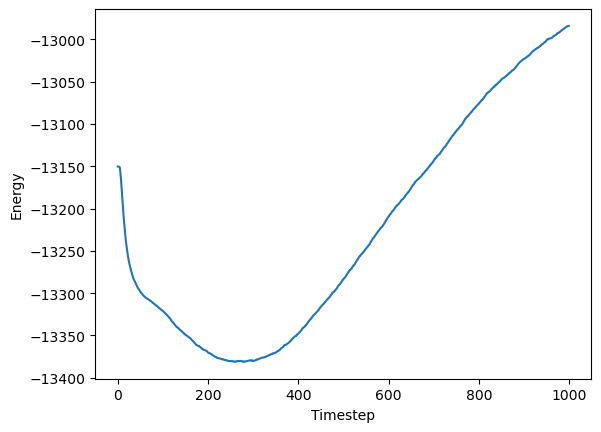

In [41]:
test = Simulation('test',kBT=1.0)
test.run(1000)
test.plot_total_energy()

#### 1. Characterize your model's behavior at N/V = 0.5 in the NVT ensemble.
a. Above what temperature is your system "hot"? How do you know?<br>
b. Below what temperature is your system "frozen"? How do you know?<br>
c. How does the system's total energy, potential energy, kinetic energy, heat capacity, and structure vary from frozen to too hot?<br>

#### 2. Characterize finite size effects.
a. How small is too small to be correct? How large is too large to be practical?

#### 3. Contrast your system with an ideal gas.<br>
a. How does the structure of your model vary with state, and how does it compare to particles with no interactions?<br>
b. Does the heat capacity of your system depend on state differently than an ideal gas?<br>
c. Can you derive or numerically determine an equation of state?

#### 4. Summarize your observations, challenges, and any revelations you had while working towards 1-3. Which specific simulation and state point was your favorite and why?